In [4]:
import tensorflow as tf
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print("GPU available: ", len(tf.config.list_physical_devices('GPU')))

GPU available:  1


In [3]:
SEED = 123456
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC']='1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

EXPLORING THE MNIST DATASET

In [5]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test)=fashion_mnist.load_data()
assert x_train.shape == (60000,28,28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape ==(60000,)
assert y_test.shape == (10000,)

4422102/4422102 [==============================] - 0s 0us/step


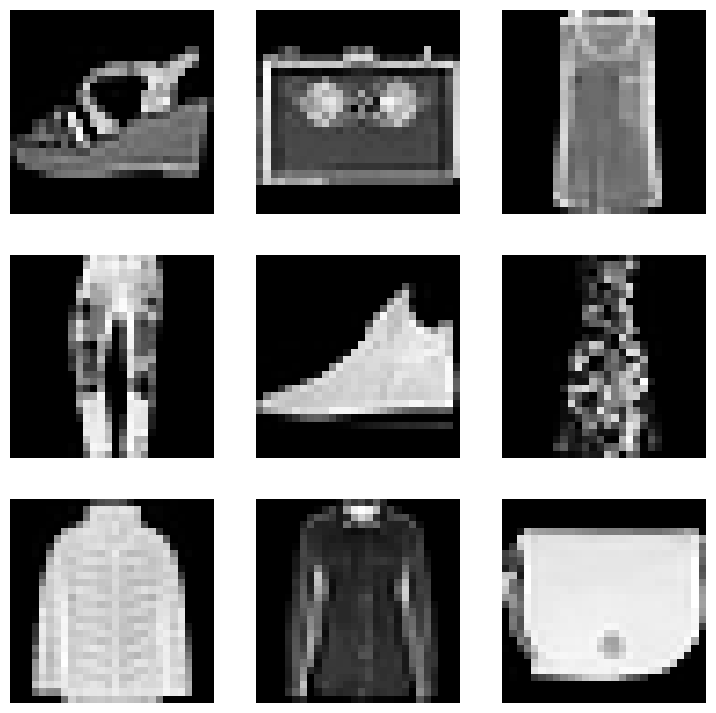

In [7]:
plt.figure(figsize=(9,9))
rndSamples = np.random.choice(60000,9)

for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(x_train[rndSamples[i]], cmap='Greys_r')
  plt.axis('off')
plt.show()

In [43]:
dataset = np.concatenate([x_train, x_test], axis = 0)
dataset = np.expand_dims(dataset, -1).astype('float32')/255
dataset.shape

(70000, 28, 28, 1)

In [44]:
from tensorflow import keras
from tensorflow.keras import layers

class SamplingLayer(layers.Layer):
  def call(self, inputs):
    zMean, zLogVar = inputs
    batch = tf.shape(zMean)[0]
    dim = tf.shape(zMean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return zMean + tf.exp(0.5 * zLogVar)*epsilon

In [46]:
def buildEncoder(latentDim, encoderInputs):
  l1 = tf.keras.models.Sequential([
      layers.Conv2D(128, 3, activation='relu', strides=2, padding ='same'),
      layers.Conv2D(64, 3, activation='relu', strides= 2, padding = 'same'),
      layers.Flatten(),
      layers.Dense(256, activation='relu')
  ])

  x=l1(encoderInputs)

  zMean = layers.Dense(latentDim, name='z_mean')(x)
  zLogVar = layers.Dense(latentDim, name='z_log_var')(x)
  z=SamplingLayer()([zMean,zLogVar])
  return tf.keras.Model(encoderInputs, [zMean, zLogVar, z], name='encoder')

encoderInputs = tf.keras.Input(shape=(28,28,1))
encoder = buildEncoder(2, encoderInputs)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential_9 (Sequential)      (None, 256)          878144      ['input_15[0][0]']               
                                                                                                  
 z_mean (Dense)                 (None, 2)            514         ['sequential_9[0][0]']           
                                                                                                  
 z_log_var (Dense)              (None, 2)            514         ['sequential_9[0][0]']           
                                                                                            

In [47]:
def buildDecoder(latentInputs):
  l1 = tf.keras.models.Sequential([
      layers.Dense(7*7*64, activation='relu', input_shape=(latentInputs.shape[1],)),
      layers.Reshape((7,7,64)),
      layers.Conv2DTranspose(128,3, activation='relu', strides=2, padding='same'),
      layers.Conv2DTranspose(64,3,activation ='relu', strides=2, padding ='same'),
      layers.Conv2DTranspose(1,3,activation='sigmoid', padding ='same')
  ])
  return tf.keras.Model(latentInputs, l1(latentInputs),name='decoder')

#actual models
latentInputs=tf.keras.Input(shape=(2,))
decoder = buildDecoder(latentInputs)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 2)]               0         
                                                                 
 sequential_10 (Sequential)  (None, 28, 28, 1)         157633    
                                                                 
Total params: 157,633
Trainable params: 157,633
Non-trainable params: 0
_________________________________________________________________


In [49]:
def reconstructionLoss(data, reconstructed):
  return tf.reduce_mean(
      tf.reduce_sum(
          keras.losses.binary_crossentropy(data, reconstructed),
          axis=(1,2)
      )
  )

In [20]:
def klDivergenceLoss(zMean, zLogVar):
  return tf.reduce_mean(
      tf.reduce_sum(
          -0.5 * (1+zLogVar-tf.square(zMean)-tf.exp(zLogVar)),
          axis=1
      )
  )

In [53]:
def calcTotalLoss(data, reconstructed, zMean, zLogVar):
  loss1 = reconstructionLoss(data, reconstructed)
  loss2 = klDivergenceLoss(zMean, zLogVar)
  klWeight = 3.0
  return loss1, loss2, loss1 + klWeight * loss2

In [58]:
# class VAE(tf.keras.Model):
#   def __init__(self, encoder, decoder, **kwargs):
#     super(VAE, self).__init__(**kwargs)
#     self.encoder = encoder
#     self.decoder = decoder
#     self.totalLossTracker=keras.metrics.Mean(name='total_loss')
#     self.ceLossTracker=keras.metrics.Mean(name='ce_loss')
#     self.klLossTracker=keras.metrics.Mean(name="kl_loss")

#     @property
#     def metrics(self):
#       return[
#           self.totalLossTracker,
#           self.ceLossTracker,
#           self.klLossTracker
#       ]

#     def train_step(self, data):
#       with tf.GradientTape() as tape:
#         zMean, zLogVar, z = self.encoder(data)
#         reconstruction=self.decoder(z)
#         ceLoss, klLoss, totalLoss = calcTotalLoss(data, reconstruction, zMean, zLogVar)
#       grads = tape.gradient(totalLoss, self.trainable_weights)
#       self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

#       self.totalLossTracker.update_state(totalLoss)
#       self.ceLossTracker.update_state(ceLoss)
#       self.klLossTracker.update_state(klLoss)

#       return{
#           "total_loss":self.totalLossTracker.result(),
#           "ce_loss":self.ceLossTracker.result(),
#           "kl_loss":self.klLossTracker.result()
#       }


In [61]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.totalLossTracker = keras.metrics.Mean(name='total_loss')
        self.ceLossTracker = keras.metrics.Mean(name='ce_loss')
        self.klLossTracker = keras.metrics.Mean(name='kl_loss')

    @property
    def metrics(self):
        return [self.totalLossTracker, self.ceLossTracker, self.klLossTracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            zMean, zLogVar, z = self.encoder(data)
            reconstruction = self.decoder(z)
            ceLoss, klLoss, totalLoss = calcTotalLoss(data, reconstruction, zMean, zLogVar)
        grads = tape.gradient(totalLoss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.totalLossTracker.update_state(totalLoss)
        self.ceLossTracker.update_state(ceLoss)
        self.klLossTracker.update_state(klLoss)

        return {
            "total_loss": self.totalLossTracker.result(),
            "ce_loss": self.ceLossTracker.result(),
            "kl_loss": self.klLossTracker.result(),
            # "reconstruction": reconstruction,
        }


In [62]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
history =vae.fit(dataset, epochs=32, batch_size=128)

Epoch 1/32
547/547 [==============================] - 17s 24ms/step - total_loss: 280.4002 - ce_loss: 266.8315 - kl_loss: 4.5229
Epoch 2/32
547/547 [==============================] - 13s 24ms/step - total_loss: 277.1577 - ce_loss: 263.2070 - kl_loss: 4.6502
Epoch 3/32
547/547 [==============================] - 13s 24ms/step - total_loss: 275.5883 - ce_loss: 261.3691 - kl_loss: 4.7398
Epoch 4/32
547/547 [==============================] - 13s 24ms/step - total_loss: 274.4119 - ce_loss: 259.9275 - kl_loss: 4.8281
Epoch 5/32
547/547 [==============================] - 13s 23ms/step - total_loss: 273.5058 - ce_loss: 258.8677 - kl_loss: 4.8793
Epoch 6/32
547/547 [==============================] - 13s 23ms/step - total_loss: 272.6824 - ce_loss: 257.8943 - kl_loss: 4.9294
Epoch 7/32
547/547 [==============================] - 13s 23ms/step - total_loss: 272.1199 - ce_loss: 257.2337 - kl_loss: 4.9621
Epoch 8/32
547/547 [==============================] - 13s 23ms/step - total_loss: 271.5491 - ce_l

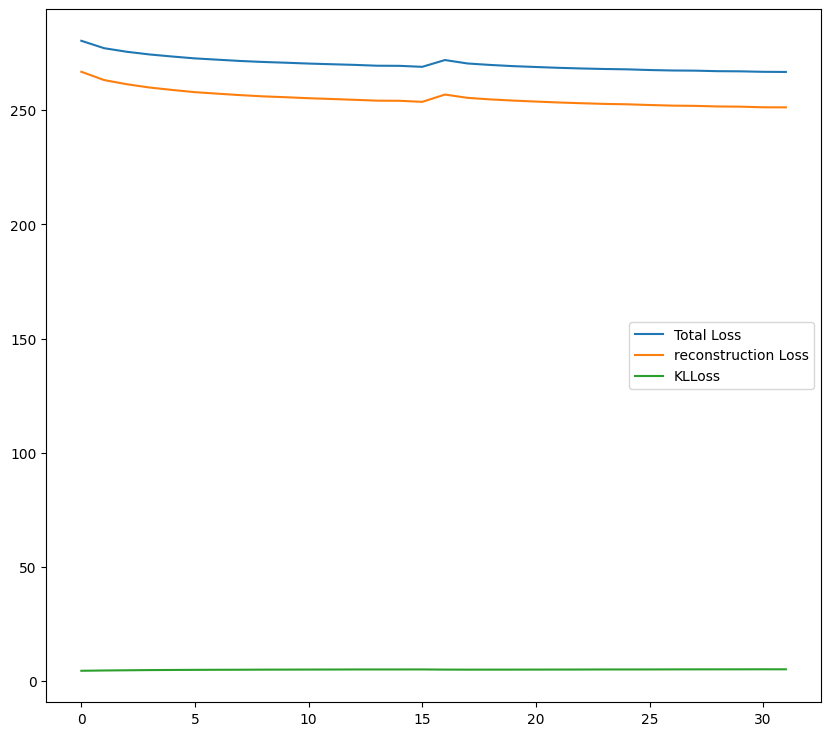

In [63]:
plt.figure(figsize=(10,9))
plt.plot(history.history.get("total_loss"), label='Total Loss')
plt.plot(history.history.get("ce_loss"), label='reconstruction Loss')
plt.plot(history.history.get("kl_loss"), label='KLLoss')
plt.legend();

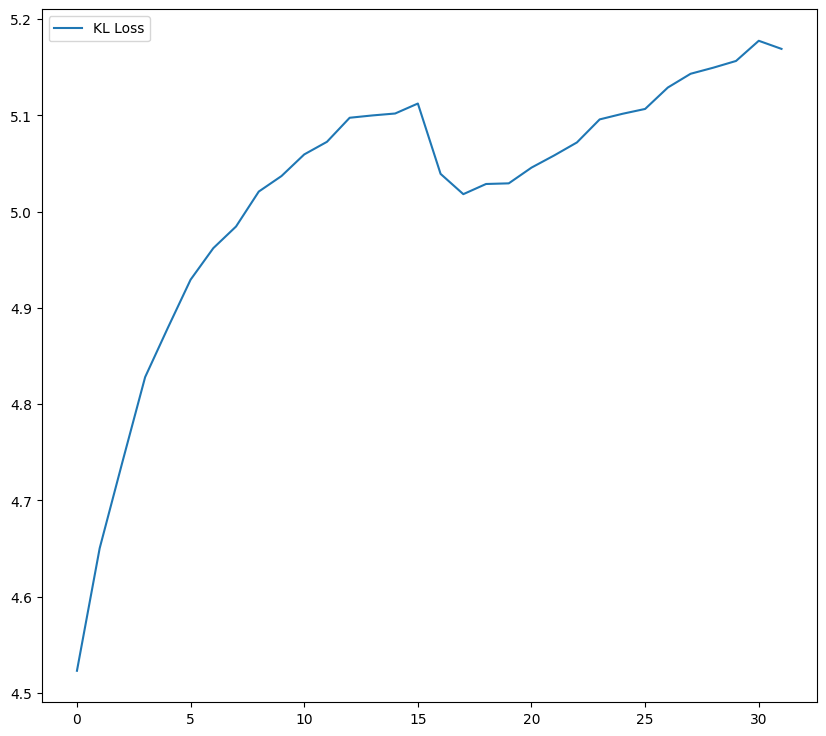

In [64]:
plt.figure(figsize=(10,9))
plt.plot(history.history.get("kl_loss"), label='KL Loss')
plt.legend();

1/1 [==============================] - 0s 51ms/step


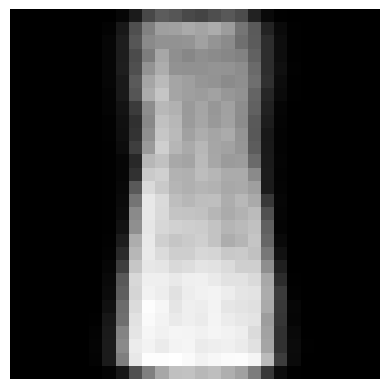

In [66]:
synth =vae.decoder.predict([[1,2]])
plt.axis('off')
plt.imshow(synth.reshape((28,28)), cmap='Greys_r');

8/8 [==============================] - 0s 6ms/step


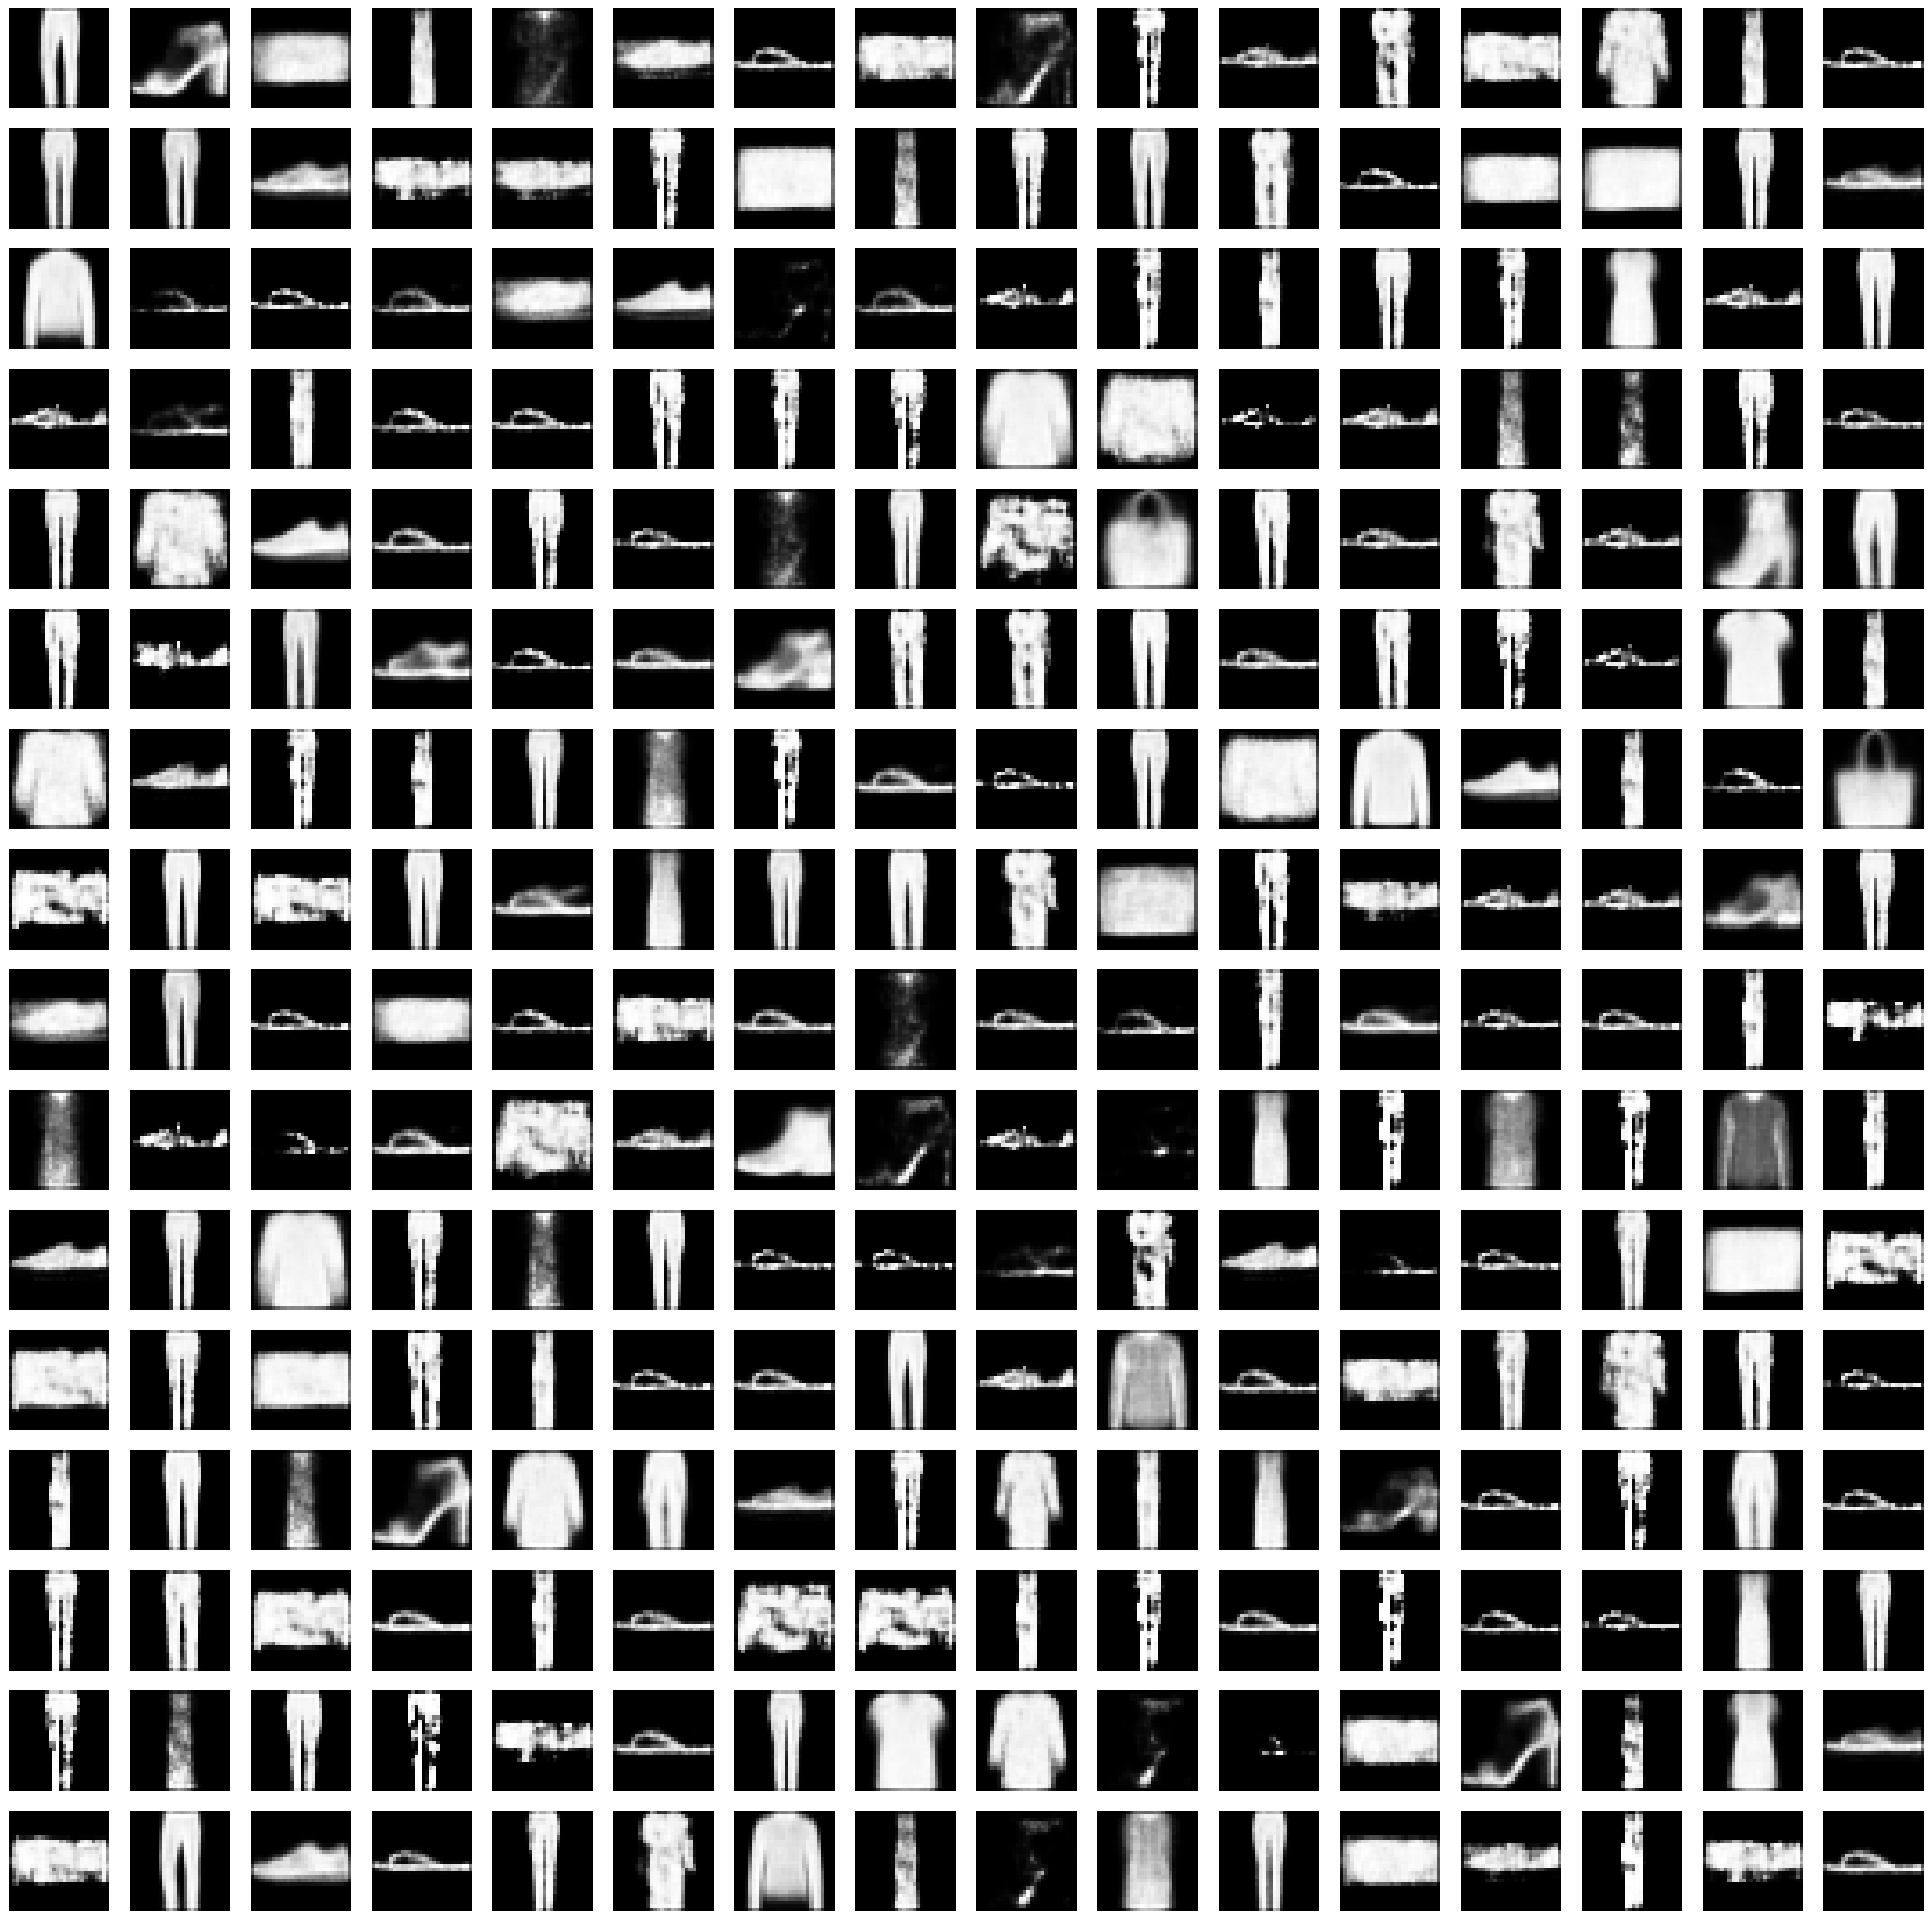

In [67]:
z=np.random.normal(loc=0,scale=4, size=(256,2))
synth = vae.decoder.predict(z)

plt.figure(figsize=(28,28))

for i in range(256):
  plt.subplot(16,16,i+1)
  plt.imshow(synth[i].reshape((28,28)), cmap="Greys_r")
  plt.axis('off')
plt.show();

In [68]:
idx =120
batch = np.expand_dims(x_train[idx], axis=0)
batchOfImages = np.expand_dims(batch, axis=-1).astype('float32')/255
print(batchOfImages.shape)
_,_, z = vae.encoder.predict(batchOfImages)

synth = vae.decoder.predict([z])
z

(1, 28, 28, 1)
1/1 [==============================] - 0s 144ms/step


array([[-1.2830768,  1.2280626]], dtype=float32)

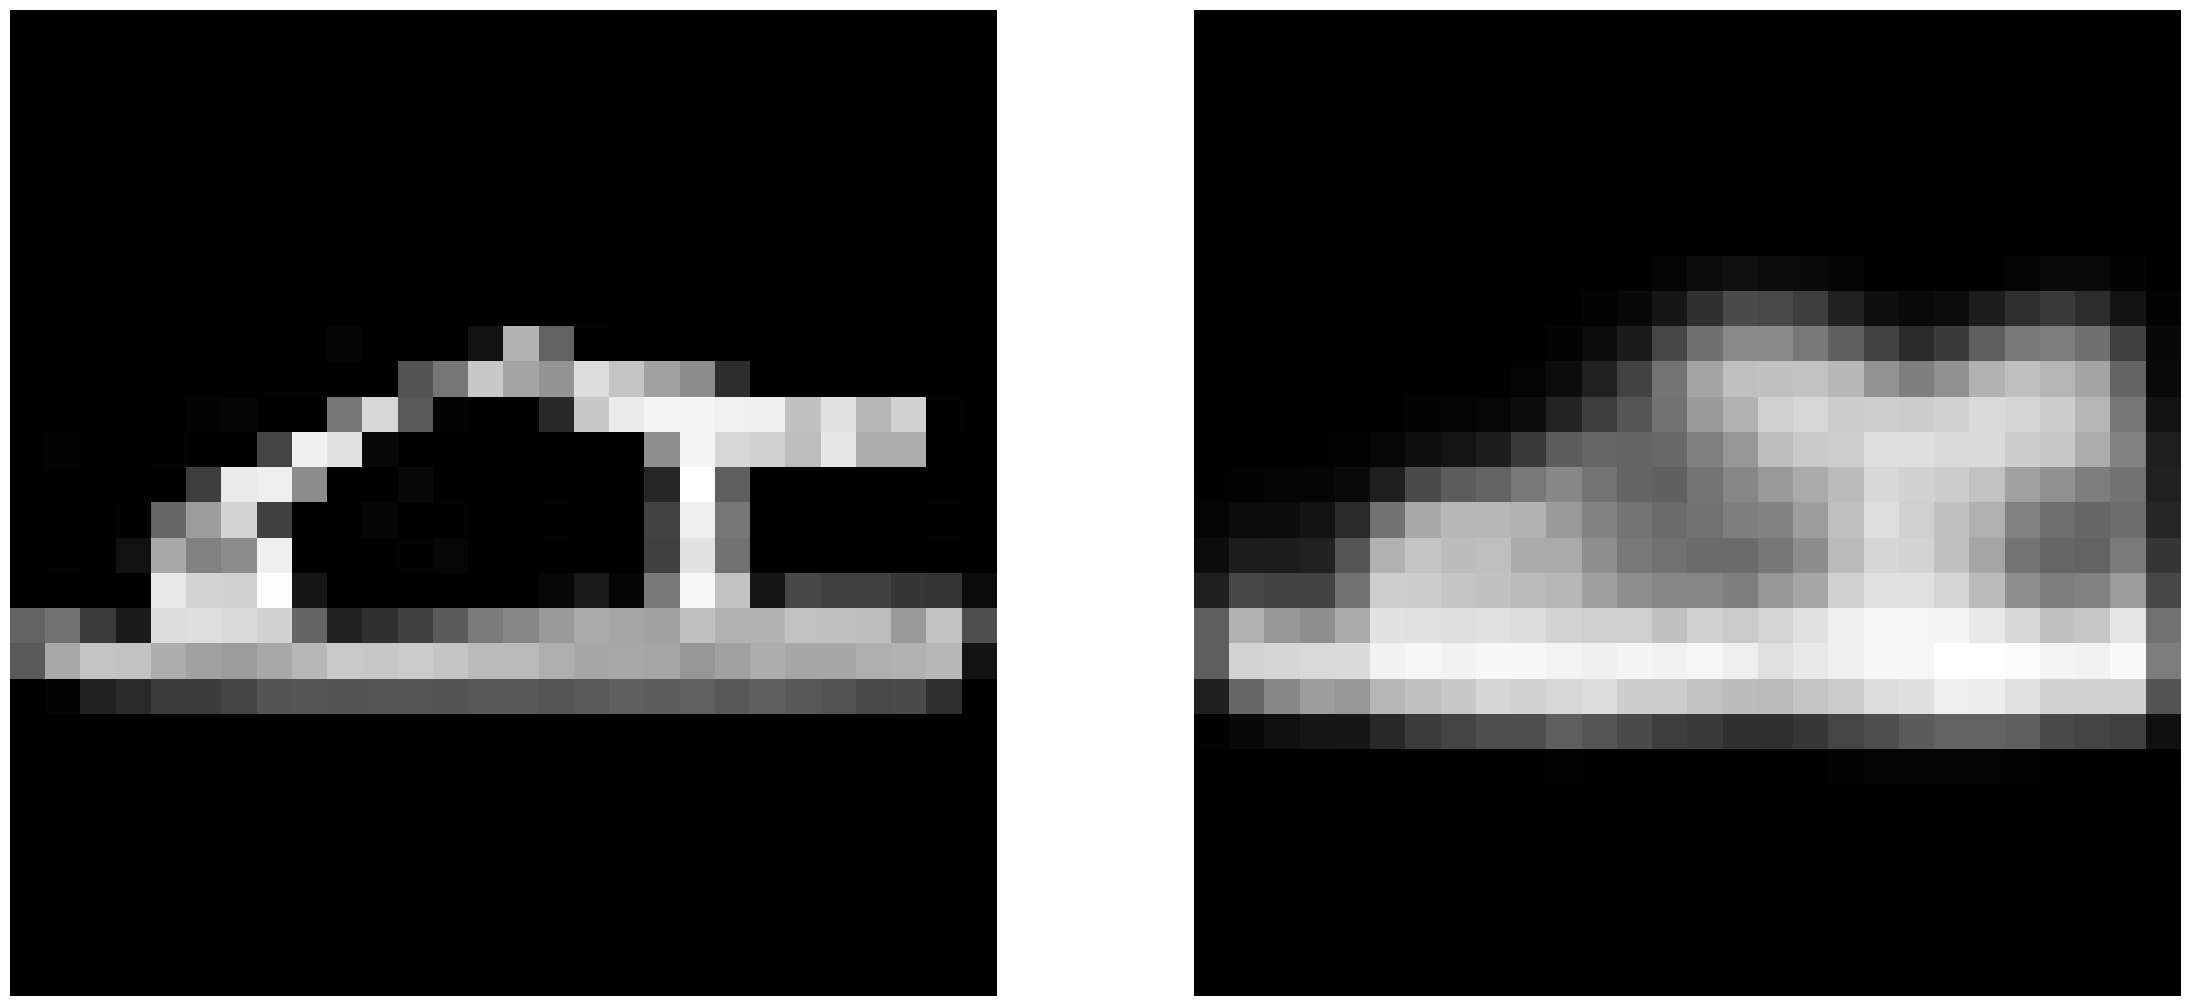

In [70]:
plt.figure(figsize=(28,28))

plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(x_train[idx], cmap='Greys_r')

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(synth[0], cmap='Greys_r')
plt.show();